# (A4) 빅데이터 혁신공유대학 여름캠프 (고한규)
> 강화학습, Mario

- toc:true
- branch: master
- badges: true
- comments: true
- author: 고한규

## 1. Setup a Mario Environment

In [ ]:
!pip install gym_super_mario_bros --quiet
!pip install nes_py --quiet

In [ ]:
# Import the Super Mario Pros
import gym_super_mario_bros

# Import the Joypad wrapper
from nes_py.wrappers import JoypadSpace

# Import the Simplified Controls
from gym_super_mario_bros.actions import SIMPLE_MOVEMENT

In [ ]:
SIMPLE_MOVEMENT

[['NOOP'],
 ['right'],
 ['right', 'A'],
 ['right', 'B'],
 ['right', 'A', 'B'],
 ['A'],
 ['left']]

In [ ]:
!pip install pyvirtualdisplay > /dev/null 2>&1 --quiet
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1

In [ ]:
from gym.wrappers import Monitor
import glob
import io
import base64
from IPython.display import HTML
from pyvirtualdisplay import Display
from IPython import display as ipythondisplay

display = Display(visible=0, size=(1400, 900))
display.start()

In [ ]:
# Wrap the Mario Environment with Monitor for Video Recording
def wrap_env(env):
    env = Monitor(env, './video', force=True)
    return env

# Play the recorded video
def show_video():
    mp4list = glob.glob('video/*.mp4')
    if len(mp4list) > 0:
        mp4 = mp4list[0]
        video = io.open(mp4, 'r+b').read()
        encoded = base64.b64encode(video)
        ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
    else:
        print("Could not find video")

In [ ]:
# Make and Wrap the Mario Environment
env = wrap_env(gym_super_mario_bros.make('SuperMarioBros-v0'))

# Reset the Mario Environment
observation = env.reset()

# Do random action 1000 times
for i in range(1000):

    # Rendering
    env.render()

    # Random action
    action = env.action_space.sample()

    # Perform the action
    observation, reward, done, info = env.step(action)

# Close the Mario Environment
env.close()

In [ ]:
# Play the recorded actions
show_video()

## 2. Preprocess the Mario Environment

In [ ]:
!pip install stable-baselines3[extra] --quiet

     |████████████████████████████████| 1.1 MB 5.1 MB/s 
     |████████████████████████████████| 1.6 MB 41.2 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done


In [ ]:
# Import FrameStacker and GrayScaling Wrapper
from gym.wrappers import FrameStack, GrayScaleObservation

# Import Vectorization Wrapper
from stable_baselines3.common.vec_env import VecFrameStack, DummyVecEnv

# Import Matplotlib
from matplotlib import pyplot as plt

In [ ]:
# Create the base environment
env = gym_super_mario_bros.make('SuperMarioBros-v0')

# Simplify the controls
env = JoypadSpace(env, SIMPLE_MOVEMENT)

# Make it as grayscale
env = GrayScaleObservation(env, keep_dim=True)

# Wrap inside the Dummy Environment
env = DummyVecEnv([lambda: env])

# Stack the Frames
env = VecFrameStack(env, 4, channels_order='last')

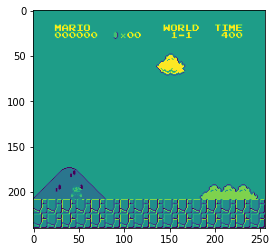

In [ ]:
observation = env.reset()
plt.imshow(observation[0][:,:,3])

In [ ]:
observation, _, _, _ = env.step([env.action_space.sample()])

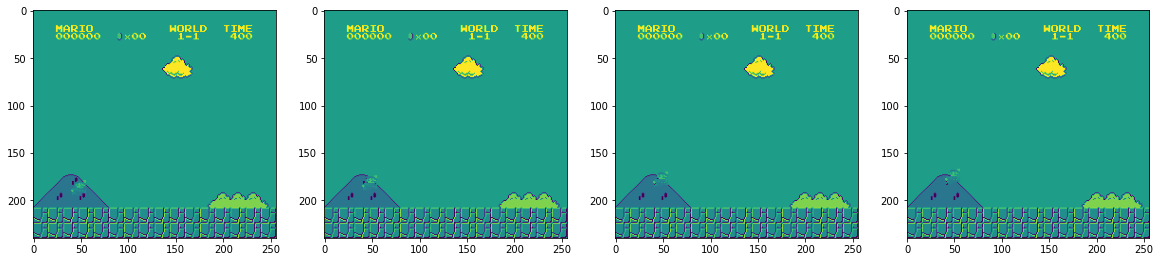

In [ ]:
for i in range(4):
  observation, _, _, _ = env.step([5])

plt.figure(figsize=(20,16))
for i in range(observation.shape[3]):
  plt.subplot(1, 4, i+1)
  plt.imshow(observation[0][:,:,i])
plt.show()

## 3. Train a RL Model

In [ ]:
# Import PPO for RL algorithm
from stable_baselines3 import PPO

# Import Base Callback for saving models
from stable_baselines3.common.callbacks import BaseCallback

# Import os for file path
import os

In [ ]:
# Save the trained model for every n-steps
class TrainAndLoggingCallback(BaseCallback):
    
    def __init__(self, check_freq, save_path, verbose=1):
        super(TrainAndLoggingCallback, self).__init__(verbose)
        self.check_freq = check_freq
        self.save_path = save_path
    
    def _init_callback(self):
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)
    
    def _on_step(self):
        if self.n_calls % self.check_freq == 0:
            model_path = os.path.join(self.save_path, 'best_model_{}'.format(self.n_calls))
            self.model.save(model_path)
        
        return True

In [ ]:
CHECKPOINT_DIR = './train/'
LOG_DIR = './logs/'

In [ ]:
# Setup model saving callback
callback = TrainAndLoggingCallback(check_freq=1000, save_path=CHECKPOINT_DIR)

In [ ]:
# Define RL model with PPO
model = PPO('CnnPolicy', env, verbose=1, tensorboard_log=LOG_DIR, learning_rate=0.0001, n_steps=512)

Using cpu device
Wrapping the env in a VecTransposeImage.


In [ ]:
# Train the RL model
model.learn(total_timesteps=2000, callback=callback)

Logging to ./logs/PPO_2
----------------------------
| time/              |     |
|    fps             | 48  |
|    iterations      | 1   |
|    time_elapsed    | 10  |
|    total_timesteps | 512 |
----------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 8           |
|    iterations           | 2           |
|    time_elapsed         | 127         |
|    total_timesteps      | 1024        |
| train/                  |             |
|    approx_kl            | 0.009011421 |
|    clip_fraction        | 0.0859      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.94       |
|    explained_variance   | -0.00126    |
|    learning_rate        | 0.0001      |
|    loss                 | 3.32        |
|    n_updates            | 10          |
|    policy_gradient_loss | -0.00303    |
|    value_loss           | 65.5        |
-----------------------------------------
-----------------

## 4. Test the Trained Model

In [ ]:
# Load the trained RL model
model = PPO.load('./train/best_model_2000')

In [ ]:
# Start the Mario
observation = env.reset()

# Do predicted action 2000 times
for i in range(2000):

  # Predict the best action
  action, _ = model.predict(observation)

  # Perform the action
  observation, reward, done, info = env.step(action)

  # Rendering
  env.render()

# Close the Mario Environment
env.close()

In [ ]:
# Play the recorded actions
show_video()